In [127]:
import json
import numpy as np
from pathlib import Path

In [128]:
def rectangle_intersection_check(rect1, rect2):
    x1_center, y1_center, w1, h1 = rect1
    x2_center, y2_center, w2, h2 = rect2
    x1_top = x1_center - w1/2
    y1_top = y1_center + h1/2
    x2_top = x2_center - w2/2
    y2_top = y2_center + h2/2
    if x1_top + w1 < x2_top or y1_top < y2_top - h2 or x1_top > x2_top + w2 or y1_top - h1 > y2_top:
        return False
    return True

def find_intersection_area(rect1, rect2):
    x1_center, y1_center, w1, h1 = rect1
    x2_center, y2_center, w2, h2 = rect2
    x1_top = x1_center - w1/2
    y1_top = y1_center + h1/2
    x2_top = x2_center - w2/2
    y2_top = y2_center + h2/2
    
    if not rectangle_intersection_check(rect1=rect1, rect2=rect2):
        return 0
    
    x_intersection = max(x1_top, x2_top)
    y_intersection = min(y1_top, y2_top)
    w_intersection = min(x1_top + w1, x2_top + w2) - x_intersection
    h_intersection = y_intersection - min(y1_top - h1, y2_top - h2)

    return w_intersection * h_intersection
    
    
def normalize_bounding_boxes(json_data):
    image_width = json_data['image']['width']
    image_height = json_data['image']['height']

    for annotation in json_data['annotations']:
        bbox = annotation['bounding_box']
        bbox['h'] /= image_height
        bbox['w'] /= image_width
        bbox['x'] /= image_width
        bbox['y'] /= image_height

    return json_data

def read_txt_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    bboxes = []
    classes = []
    for line in lines:
        elements = line.split()
        class_id = int(elements[0])
        classes.append(class_id)
        bbox = [float(e) for e in elements[1:]]
        bboxes.append( bbox)
    return np.array(classes), np.array(bboxes)

def find_max_intersection(json_data, classes, txt_bboxes):
    assigned_classes = set()
    for annotation in json_data['annotations']:
        json_bbox = list(annotation['bounding_box'].values())
        max_intersection = 0
        max_class_id = None
        for (class_id, txt_bbox) in zip(classes, txt_bboxes):
            if class_id in assigned_classes:
                continue
            intersection = find_intersection_area(json_bbox, txt_bbox)
            if intersection > max_intersection:
                max_intersection = intersection
                max_class_id = class_id
        if max_class_id is not None:
            annotation['class'] = max_class_id
            assigned_classes.add(max_class_id)
    return json_data


In [129]:
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(NumpyEncoder, self).default(obj)

In [130]:
source_path = Path("C:\\Users\\AMET\\DocGaid\\diploma\\data\\full_teeth\\labels")
json_path = Path("C:\\Users\\AMET\\DocGaid\\yolov8\\data\\annotations")
output_path = Path("C:\\Users\\AMET\\DocGaid\\yolov8\\data\\annotations_classes")

In [131]:
import natsort

file_paths = sorted(list(source_path.glob("*.txt")))
file_paths = natsort.natsorted(file_paths)

for file_name in file_paths:
    txt_file_path = source_path / file_name.name
    json_file_path = json_path / file_name.with_suffix('.json').name
    output_file_path = output_path / file_name.with_suffix('.json').name
    
    if json_file_path.exists():
        with open(json_file_path, 'r') as file:
            json_data = json.load(file)
    else:
        break
    
    json_data = normalize_bounding_boxes(json_data)
    
    classes , txt_bboxes = read_txt_file(txt_file_path)

    for annotation in json_data['annotations']:
        x_json_bbox = annotation['bounding_box']['x']
        y_json_bbox = annotation['bounding_box']['y']
        w_json_bbox = annotation['bounding_box']['w']
        h_json_bbox = annotation['bounding_box']['h']
        json_bbox = [x_json_bbox,y_json_bbox,w_json_bbox,h_json_bbox]

        max_intersection = 0
        max_class_id = -1
        for (class_id, txt_bbox) in zip(classes, txt_bboxes):
            intersection = find_intersection_area(json_bbox, txt_bbox)
            if intersection > 0:
                pass
            if intersection > max_intersection:
                
                max_intersection = intersection
                max_class_id = class_id
                
        annotation['class'] = max_class_id
        
    final_data = find_max_intersection(json_data, classes, txt_bboxes)
    
    with open(output_file_path, 'w') as output_file:
        json.dump(json_data, output_file, cls=NumpyEncoder, indent=4)

    # print(f"Final data for '{file_name}' saved to '{output_file_path}'")

In [132]:
txt_file_path = source_path / '1.txt'
json_file_path = json_path /  '1.json'
output_file_path = output_path / '1.json'
    
if json_file_path.exists():
    with open(json_file_path, 'r') as file:
        json_data = json.load(file)

json_data = normalize_bounding_boxes(json_data)

classes , txt_bboxes = read_txt_file(txt_file_path)
for annotation in json_data['annotations']:
    x_json_bbox = annotation['bounding_box']['x']
    y_json_bbox = annotation['bounding_box']['y']
    w_json_bbox = annotation['bounding_box']['w']
    h_json_bbox = annotation['bounding_box']['h']
    json_bbox = [x_json_bbox,y_json_bbox,w_json_bbox,h_json_bbox]
    max_intersection = 0
    max_class_id = None
    for i, (class_id, txt_bbox) in enumerate(zip(classes, txt_bboxes)):

        intersection = find_intersection_area(json_bbox, txt_bbox)
        if intersection > max_intersection:
            max_intersection = intersection
            max_class_id = class_id
            max_bbox_index = i
            
    annotation['class'] = max_class_id
    print(annotation['class'])
    
with open(output_file_path, 'w') as output_file:
    json.dump(json_data, output_file, cls=NumpyEncoder, indent=4)


3
4
4
6
5
10
10
11
16
20
17
17
10
11
21
22
24
26
2
3
29
30
31
12
31
13


In [33]:
classes , txt_bboxes = read_txt_file(txt_file_path)
print(txt_bboxes[0])
assigned_classes = set()
for annotation in json_data['annotations']:
    json_bbox = list(annotation['bounding_box'].values())
    max_intersection = 0
    max_class_id = None
    # print(txt_bboxes)
    for (class_id, txt_bbox) in zip(classes, txt_bboxes):
        if class_id in assigned_classes:
            continue
        intersection = find_intersection_area(json_bbox, txt_bbox)
        if intersection > max_intersection:
            max_intersection = intersection
            max_class_id = class_id
    if max_class_id is not None:
        annotation['class'] = max_class_id
        assigned_classes.add(max_class_id)
print(max_class_id)
 

C:\Users\AMET\DocGaid\diploma\data\full_teeth\labels\1.txt
[0.25596774 0.34846154 0.04806452 0.22307692]
None


In [86]:
def relative_to_image_size(shape, bbox):
    x = bbox[0] * shape[1]
    y = bbox[1] * shape[0]
    width = bbox[2] * shape[1]
    height = bbox[3] * shape[0]
    return x, y, width, height
    
def xywh2xyxy(bbox):
    xc,yc,w,h = bbox
    x1 = int(xc - w/2)
    y1 = int(yc + h/2)
    y2 = int(yc - h/2)
    x2 = int(xc + w/2)
    return (x1, y1) , (x2, y2)
    
         

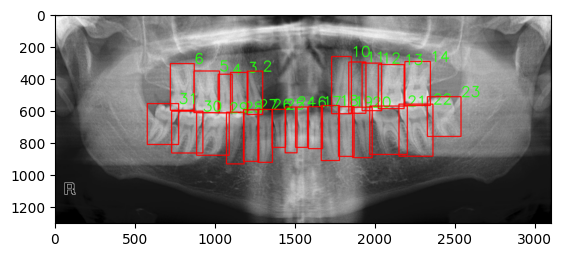

In [124]:
import cv2
import matplotlib.pyplot as plt 

source_path = "C:\\Users\\AMET\\DocGaid\\diploma\\data\\full_teeth\\labels\\1.txt"
image_path = "C:\\Users\\AMET\\DocGaid\\diploma\\data\\full_teeth\\images\\1.jpg"
image = cv2.imread(image_path)
shape = image.shape

classes, bbox_info = read_txt_file(source_path)
for index in range(len(classes)):
    tooth_class = str(classes[index])
    xc,yc,w,h = relative_to_image_size(shape, bbox_info[index])
    bbox = (xc,yc,w,h)
    start_point, end_point = xywh2xyxy(bbox)
    color = (255, 0 ,0) 
    thickness = 5
    text_position = end_point
    cv2.rectangle(image, start_point, end_point, color, thickness)
    cv2.putText(image, tooth_class, text_position, cv2.FONT_HERSHEY_SIMPLEX, 3, (36,255,12), 5)
    plt.imshow(image) 

plt.show() 

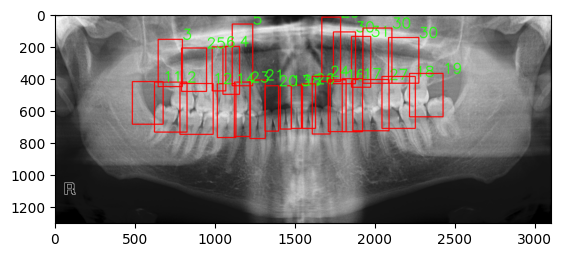

In [125]:
import cv2
import matplotlib.pyplot as plt 

source_path = "C:\\Users\\AMET\\DocGaid\\yolov8\\data\\labels\\val\\1.txt"
image_path = "C:\\Users\\AMET\\DocGaid\\yolov8\\data\\segmentation_data\\images\\val\\1.png"
image = cv2.imread(image_path)
shape = image.shape

classes, bbox_info = read_txt_file(source_path)
for index in range(len(classes)):
    tooth_class = str(classes[index])
    xc,yc,w,h = relative_to_image_size(shape, bbox_info[index])
    bbox = (xc,yc,w,h)
    start_point, end_point = xywh2xyxy(bbox)
    color = (255, 0 ,0) 
    thickness = 5
    text_position = end_point
    cv2.rectangle(image, start_point, end_point, color, thickness)
    cv2.putText(image, tooth_class, text_position, cv2.FONT_HERSHEY_SIMPLEX, 3, (36,255,12), 5)
    plt.imshow(image) 

plt.show() 

In [6]:
source_path = "C:\\Users\\AMET\\DocGaid\\diploma\\data\\full_teeth\\labels\\1.txt"

In [9]:
boxes = read_txt_file(source_path)
print(boxes[0][1])

[0.2559677419354839, 0.3484615384615385, 0.04806451612903226, 0.2230769230769231]
